In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
!git clone https://github.com/Amey-2002/GSoC_2022_QMLHEP

Cloning into 'GSoC_2022_QMLHEP'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 223 (delta 4), reused 8 (delta 3), pack-reused 212
Receiving objects: 100% (223/223), 1.76 MiB | 11.79 MiB/s, done.
Resolving deltas: 100% (112/112), done.


In [ ]:
# To remove the cloned repo from the folders section, uncomment the following command

# !rm -rf GSoC_2022_QMLHEP

In [3]:
%cd /content/GSoC_2022_QMLHEP/

/content/GSoC_2022_QMLHEP


In [4]:
from IPython.display import clear_output
!pip install tensorflow-quantum==0.6.0 --use-deprecated=legacy-resolver
clear_output()

## Getting the imports 

In [5]:
import numpy as np
import tensorflow as tf
from h5py import File as HDF5File
from QGANSHEP.Quantum_Conv2D_layer import QConv2D_layer
from QGANSHEP import preprocess_utils, model, swap_test_layer, frechet_inception_distance, visualizations
%matplotlib inline
import matplotlib.pyplot as plt

## Fetching and Preprocessing the dataset



In [ ]:
electron_datafile = '/content/gdrive/MyDrive//electron.hdf5'
photon_datafile = '/content/gdrive/MyDrive//photon.hdf5'

In [ ]:
electron_data = HDF5File(electron_datafile, 'r')
photon_data = HDF5File(photon_datafile, 'r')

In [ ]:
electron_data.keys()

<KeysViewHDF5 ['X', 'y']>

In [ ]:
X_electron = electron_data['X']

In [ ]:
X_electron.shape

(249000, 32, 32, 2)

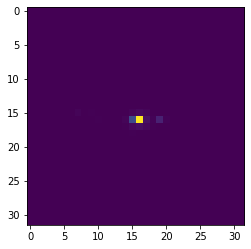

In [ ]:
#Let's have a look on one of the images
plt.imshow(X_electron[0,:,:,0])

In [ ]:
X_electron = electron_data['X'][:,:,:,0]

In [ ]:
X_electron.shape

(249000, 32, 32)

In [ ]:
#preprocess the images(here: crop the images)X_electron = preprocess_utils.crop_images(X_electron,(8,8))
X_electron = X_electron[:300]

In [ ]:
#vanity check
X_electron.shape

(300, 32, 32)

In [ ]:
X_electron = preprocess_utils.crop_images(X_electron,(8,8))

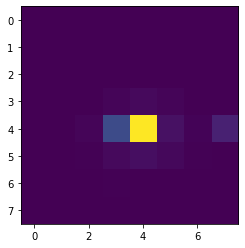

In [ ]:
#Let's have a look at the image after cropping it.
plt.imshow(X_electron[0])

## Creating the Convolutional layers

### This layers help to reduce the dimension of images and encode the information from images into a latent space

In [ ]:
def generate_data(data_inputs,circuit_layers,filters,filter_shape,stride,c_id=''):

  conv_1 = QConv2D_layer(circuit_layers=circuit_layers[0], filter_shape=filter_shape[0],conv_id ='1'+c_id,
                      filters=filters[0], stride=stride[0], padding="same", parameter_sharing=False,seed=2021)(data_inputs)
  conv_2 = QConv2D_layer(circuit_layers=circuit_layers[1], filter_shape=filter_shape[1],conv_id = '2'+c_id,
                      filters=filters[1], stride=stride[1], padding="same", parameter_sharing=False,seed=2022)(conv_1)
  conv_output = tf.keras.layers.Flatten(name='Intermediate_output_layer_'+c_id)(conv_2)

  return conv_output

## Discriminator model

In [ ]:
def create_discriminator(real_data_inputs,gen_data_inputs,
                         circuit_layers,filters,filter_size,stride,
                         fidelity_test_params,optimizer,
                         use_sampled=False,backend=None,name='Discriminator'):
  
  conv_output_gen = generate_data(gen_data_inputs,circuit_layers=circuit_layers,filters=filters,filter_shape=filter_size,stride=stride,c_id='gen')
  conv_output_real = generate_data(real_data_inputs,circuit_layers=circuit_layers,filters=filters,filter_shape=filter_size,stride=stride,c_id='real')
  fidelity_test = swap_test_layer.SwapTestLayer(swap_test_symbol_values=fidelity_test_params)
  expectation_gen = fidelity_test([conv_output_real,conv_output_gen])
  expectation_gen = tf.add(expectation_gen,tf.constant(0.000001))
  log_disc_dist = tf.math.log(tf.keras.backend.flatten(expectation_gen))
  final_output = -log_disc_dist
  discriminator_model = tf.keras.Model(inputs=[real_data_inputs,gen_data_inputs],outputs=[final_output],name=name)
  disc_optimizer = optimizer(learning_rate=0.0001)
  disc_loss = lambda x,y: -tf.reduce_mean(y)
  discriminator_model.compile(optimizer=disc_optimizer,loss=disc_loss)

  return discriminator_model 

In [ ]:
real_data_inputs = tf.keras.Input(shape=(X_electron.shape[1], X_electron.shape[2], ),dtype=tf.dtypes.float32,name='Input_layer_real')
gen_data_inputs = tf.keras.Input(shape=(X_electron.shape[1], X_electron.shape[2], ),dtype=tf.dtypes.float32,name='Input_layer_generated')
disc_layers = [2,2]
disc_filters = [1,1]
disc_filter_shape = [(3,3),(2,2)]  
disc_stride = [(2,2),(2,2)]

discriminator_model = discriminator_model = create_discriminator(                       
    real_data_inputs=real_data_inputs,
    gen_data_inputs=gen_data_inputs,
    circuit_layers=disc_layers,
    filters=disc_filters,
    filter_size=disc_filter_shape,
    stride=disc_stride,
    fidelity_test_params= np.ndarray.flatten(np.array([0.5 , 1.0] * 4)),
    optimizer=tf.keras.optimizers.Adam,
    use_sampled=False,
    backend=None,name='Discriminator_Model')

## Generator Model

In [ ]:
def create_generator(real_data_inputs,gen_data_inputs,
                         circuit_layers,filters,filter_size,stride,
                         fidelity_test_params,optimizer,
                         use_sampled=False,backend=None,name='Generator'):
  
  conv_output_gen = generate_data(gen_data_inputs,circuit_layers=circuit_layers,filters=filters,filter_shape=filter_size,stride=stride,c_id='gen')
  conv_output_real = generate_data(real_data_inputs,circuit_layers=circuit_layers,filters=filters,filter_shape=filter_size,stride=stride,c_id='real')
  fidelity_test = swap_test_layer.SwapTestLayer(swap_test_symbol_values=fidelity_test_params)
  expectation_gen = fidelity_test([conv_output_real,conv_output_gen])
  expectation_gen = tf.add(expectation_gen,tf.constant(0.000001))
  log_gen_dist = tf.math.log(tf.keras.backend.flatten(expectation_gen))
  discriminator_model = tf.keras.Model(inputs=[real_data_inputs,gen_data_inputs],outputs=[expectation_gen,log_gen_dist],name=name)
  disc_optimizer = optimizer(learning_rate=0.0001)
  disc_loss = lambda x,y: -tf.reduce_mean(y)
  discriminator_model.compile(optimizer=disc_optimizer,loss=disc_loss,loss_weights=[0,1])
  
  return discriminator_model

In [ ]:
real_data_inputs = tf.keras.Input(shape=(X_electron.shape[1], X_electron.shape[2], ),dtype=tf.dtypes.float32,name='Input_layer_real')
gen_data_inputs = tf.keras.Input(shape=(X_electron.shape[1], X_electron.shape[2], ),dtype=tf.dtypes.float32,name='Input_layer_generated')
gen_layers = [2,2]
gen_filters = [1,1]
gen_filter_shape = [(3,3),(2,2)]  
gen_stride = [(2,2),(2,2)]

generator_model = create_generator(
    real_data_inputs=real_data_inputs,
    gen_data_inputs=gen_data_inputs,
    circuit_layers=gen_layers,
    filters=gen_filters,
    filter_size=gen_filter_shape,
    stride=gen_stride,
    fidelity_test_params= np.ndarray.flatten(np.array([0.5 , 1.0] * 4)),
    optimizer=tf.keras.optimizers.Adam,
    use_sampled=False,
    backend=None,name='Generator_Model')

Note: The parameters for the Swap Test **here** are set to emulate a perfect swap test, but the actual paper of reference promotes to keep these parameters trainable by initially setting random values for them

In [ ]:
#Let's see a detailed view of how our generator and discriminator model appear
generator_model.summary()
discriminator_model.summary()

Model: "Generator_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_layer_real (InputLayer)  [(None, 8, 8)]       0           []                               
                                                                                                  
 Input_layer_generated (InputLa  [(None, 8, 8)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Quantum_Convolutional_Layer_wi  (None, 4, 4, 1)     864         ['Input_layer_real[0][0]']       
 th_padding1real (QConv2D_layer                                                                   
 )                                                                                  

## Random Data

In [ ]:
z_shape = tf.shape(X_electron)
z = tf.random.normal(z_shape)
print(tf.shape(z))

tf.Tensor([300   8   8], shape=(3,), dtype=int32)


### QGANS MODEL

In [ ]:
qgan = model.EntangledQGAN(generator_model=generator_model,discriminator_model=discriminator_model)

In [ ]:
gen_loss,disc_loss,param_history,state_overlap_list = qgan.train(real_data_inputs=X_electron,generator_data_inputs=z,
                                                                 batch_size=20,g_epochs=1,d_epochs=1,n_episodes=10) 

Step = 0:
discriminator_loss=[-0.21151980757713318]
generator_loss=[0.6057540774345398]
overlap=(0.8898388743400574+0j)
--------------------------------------------------
Step = 1:
discriminator_loss=[-0.21618789434432983]
generator_loss=[0.5959756374359131]
overlap=(0.8892693519592285+0j)
--------------------------------------------------
Step = 2:
discriminator_loss=[-0.2210230976343155]
generator_loss=[0.5863906741142273]
overlap=(0.8886693716049194+0j)
--------------------------------------------------
Step = 3:
discriminator_loss=[-0.2260563224554062]
generator_loss=[0.5770214796066284]
overlap=(0.8880417346954346+0j)
--------------------------------------------------
Step = 4:
discriminator_loss=[-0.2312961369752884]
generator_loss=[0.5678719282150269]
overlap=(0.8873865604400635+0j)
--------------------------------------------------
Step = 5:
discriminator_loss=[-0.2367590069770813]
generator_loss=[0.5589367747306824]
overlap=(0.8867040872573853+0j)
-----------------------------

### Plotting Loss

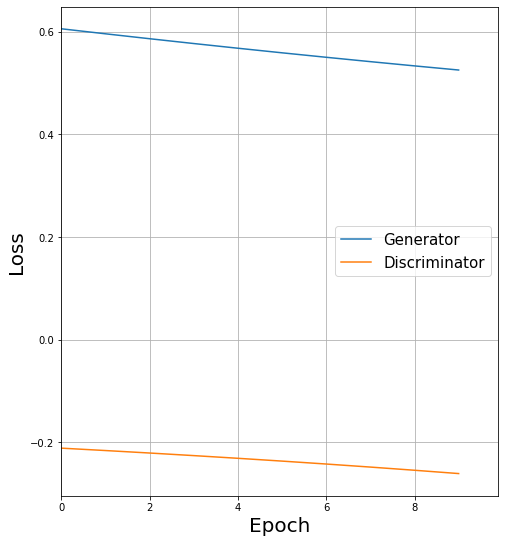

In [ ]:
visualizations.plot_loss(gen_loss,disc_loss,10)

### Plotting overlap

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


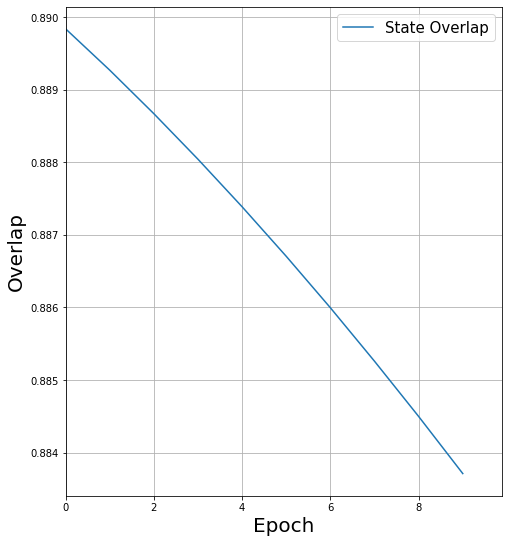

In [ ]:
visualizations.plot_state_overlap(state_overlap_list,10)

### Generating samples

Generating samples
Applying PCA to real data
Applying inverse PCA to generated samples
Generated Images:


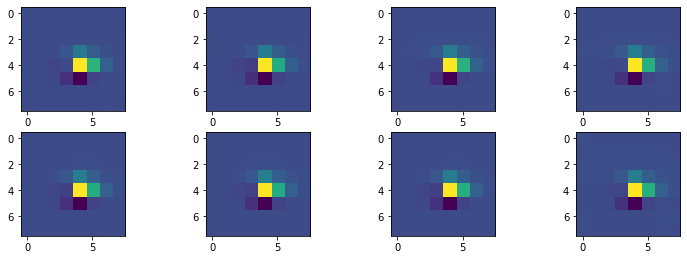

In [ ]:
samples = qgan.create_images(X_electron,z)

## FID calculation

In [ ]:
fid = frechet_inception_distance.FID()
print(f'Frechet Inception Distance for the generated images is: {fid.calculate(X_electron,samples)}')

Frechet Inception Distance for the generated images is: 6.43880908235323
